In [ ]:
# 1) Fetch the covariance and the catalog directly (no manual upload needed)
!mkdir -p /content/pantheon_cov
!wget -O /content/pantheon_cov/Pantheon+SH0ES_STAT+SYS.cov \
  "https://raw.githubusercontent.com/PantheonPlusSH0ES/DataRelease/main/Pantheon+_Data/4_DISTANCES_AND_COVAR/Pantheon+SH0ES_STAT+SYS.cov"

# (Optional) also grab the stat-only cov if you want a lighter cross-check:
!wget -O /content/pantheon_cov/Pantheon+SH0ES_STATONLY.cov \
  "https://raw.githubusercontent.com/PantheonPlusSH0ES/DataRelease/main/Pantheon+_Data/4_DISTANCES_AND_COVAR/Pantheon+SH0ES_STATONLY.cov"

# (You already uploaded the catalog, but here’s a fetch too, for completeness)
!wget -O /content/pantheon_cov/Pantheon+SH0ES.dat \
  "https://raw.githubusercontent.com/PantheonPlusSH0ES/DataRelease/main/Pantheon+_Data/4_DISTANCES_AND_COVAR/Pantheon+SH0ES.dat"

# Sanity check: sizes
!ls -lh /content/pantheon_cov


--2025-08-19 18:45:45--  https://raw.githubusercontent.com/PantheonPlusSH0ES/DataRelease/main/Pantheon+_Data/4_DISTANCES_AND_COVAR/Pantheon+SH0ES_STAT+SYS.cov
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33284960 (32M) [text/plain]
Saving to: ‘/content/pantheon_cov/Pantheon+SH0ES_STAT+SYS.cov’

/content/pantheon_c 100%[===================>]  31.74M   178MB/s    in 0.2s    

2025-08-19 18:45:46 (178 MB/s) - ‘/content/pantheon_cov/Pantheon+SH0ES_STAT+SYS.cov’ saved [33284960/33284960]

--2025-08-19 18:45:46--  https://raw.githubusercontent.com/PantheonPlusSH0ES/DataRelease/main/Pantheon+_Data/4_DISTANCES_AND_COVAR/Pantheon+SH0ES_STATONLY.cov
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133,

In [ ]:
# === Pantheon+ (STAT+SYS covariance) → SNe×BAO shared-z window (0.30–0.85) ===
# Outputs:
#   /content/eta_sdss_cov.csv, eta_desi_cov.csv, eta_combined_cov.csv
#   /content/rd_cov_results.txt
#   /content/eta_cov_plot_sdss.png, eta_cov_plot_desi.png, eta_cov_plot_combined.png

import numpy as np, pandas as pd, math, matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

# ---------- 1) Load SN data & covariance ----------
SN_DAT = "/content/pantheon_cov/Pantheon+SH0ES.dat"
SN_COV = "/content/pantheon_cov/Pantheon+SH0ES_STAT+SYS.cov"   # full stat+sys

sn = pd.read_csv(SN_DAT, delim_whitespace=True, engine="python")
# Use SH0ES-calibrated distance moduli for CDDR:
sn = sn.rename(columns={"zHD":"z", "MU_SH0ES":"mu", "MU_SH0ES_ERR_DIAG":"mu_err"})
mask = sn["z"].notna() & sn["mu"].notna()
sn = sn[mask].reset_index(drop=True)
N = len(sn)

print(f"Loaded {N} SNe for covariance use.")
# Covariance is over the MU entries; read as a dense matrix (∼31 MB)
C = np.loadtxt(SN_COV)
assert C.shape == (N,N), f"Cov shape {C.shape} does not match N={N}"

# ---------- 2) BAO inputs (z, DM/rd, err) ----------
# SDSS/eBOSS DR16  (z ≤ 0.85 points used below)
sdss = pd.DataFrame({
    "z":  [0.15, 0.38, 0.51, 0.70, 0.85, 1.48, 2.33],
    "DM_over_rd":[4.466, 10.234, 13.366, 17.858, 20.437, 33.120, 52.90],
    "DM_err":    [0.168, 0.170, 0.210, 0.355, 0.514,  0.90,   1.20]
})
# DESI DR2 (as in our earlier runs)
desi = pd.DataFrame({
    "z":  [0.30, 0.51, 0.70, 0.85, 1.10, 1.48, 2.33],
    "DM_over_rd":[8.46, 13.36, 17.73, 20.39, 25.03, 33.15, 52.90],
    "DM_err":    [0.11, 0.21, 0.29, 0.36, 0.55, 0.90,  1.20]
})

# Restrict to shared-z window 0.30–0.85
zmin, zmax = 0.30, 0.85
sdss_w = sdss[(sdss.z>=zmin)&(sdss.z<=zmax)].reset_index(drop=True)
desi_w = desi[(desi.z>=zmin)&(desi.z<=zmax)].reset_index(drop=True)

# ---------- Helpers ----------
def build_mu_spline_with_cov(z, mu):
    # Weighted smoothing using diagonal of C only for the fit *means*,
    # but we'll propagate *full* covariance via MC draws.
    # This keeps the spline well-behaved and shifts uncertainty handling to MC.
    # (Full GLS spline is possible but slower and rarely changes means.)
    # Use local scatter as weights:
    mu_err_diag = np.sqrt(np.clip(np.diag(C), 1e-10, None))
    # Bin identical z to avoid singularities
    df = pd.DataFrame({"z":z, "mu":mu, "w":1.0/np.maximum(mu_err_diag,1e-3)**2})
    g = (df.groupby(df["z"].round(5))
           .apply(lambda g: pd.Series({
               "z": g["z"].mean(),
               "mu": np.average(g["mu"], weights=g["w"]),
               "mu_err_eff": 1.0/np.sqrt(np.sum(g["w"]))
           }))
           .sort_values("z").reset_index(drop=True))
    xs, ys = g["z"].values, g["mu"].values
    ws = 1.0/np.maximum(g["mu_err_eff"].values, 1e-3)**2
    spl = UnivariateSpline(xs, ys, w=ws, s=0, k=3)
    return spl

def mu_to_DL(mu, s_mu):
    # standard relation: mu = 5 log10(DL/10 pc)
    DL = 10.0**((mu-25.0)/5.0)         # Mpc
    s_DL = DL * (math.log(10)/5.0) * s_mu
    return DL, s_DL

def cddr_eta(mu_at_z, mu_cov_at_z, bao, r_d=147.05):
    """Return eta and eta sigma at the BAO redshifts using full mu covariance projected to z."""
    z = bao["z"].values.astype(float)
    DM_over_rd = bao["DM_over_rd"].values.astype(float)
    DM_err_over_rd = bao["DM_err"].values.astype(float)

    mu = mu_at_z(z)                     # mean mu(z) from spline
    # Project SN covariance to z via numerical derivative of mu wrt original mu vector.
    # We approximate with MC using the full covariance (robust & simple).
    # MC size kept modest for speed; increase if you want even smoother errors.
    MC = 400
    rng = np.random.default_rng(42)
    # Draw correlated MU realizations at original SN positions
    draws = rng.multivariate_normal(sn["mu"].values, C, size=MC)   # shape (MC, N)
    # Build a fast 1-D spline for each draw via a small linear adjustment:
    # approximate by adding (draw - mean) via local linearization on mu
    # For stability, we re-fit a quick spline for a subset of draws.
    zs = sn["z"].values
    eta_list = []
    for i in range(MC):
        mu_draw = draws[i]
        spl_i = build_mu_spline_with_cov(zs, mu_draw)
        mu_i = spl_i(z)
        DL_i, _ = mu_to_DL(mu_i, 0.0)
        DA = (DM_over_rd * r_d) / (1.0 + z)
        eta_i = DL_i / (((1.0+z)**2) * DA)
        eta_list.append(eta_i)
    eta_arr = np.vstack(eta_list)           # (MC, nbins)
    eta_mean = eta_arr.mean(axis=0)
    # add BAO error contribution (in quadrature) using analytic propagation
    # sigma from mu (from MC):
    sigma_from_mu = eta_arr.std(axis=0, ddof=1)
    # sigma from BAO:
    DA = (DM_over_rd * r_d) / (1.0 + z)
    DL_mean, _ = mu_to_DL(mu_mean:=mu_at_z(z), 0.0)
    d_eta_d_DA = -DL_mean / (((1.0+z)**2) * DA**2)
    s_DA = (DM_err_over_rd * r_d)/(1.0 + z)
    sigma_from_bao = np.abs(d_eta_d_DA) * s_DA
    sigma_eta = np.sqrt(sigma_from_mu**2 + sigma_from_bao**2)
    return pd.DataFrame({"z":z, "eta":eta_mean, "sigma_eta":sigma_eta})

def fit_rd(mu_at_z, bao):
    z = bao["z"].values.astype(float)
    DM_over_rd = bao["DM_over_rd"].values.astype(float)
    DM_err_over_rd = bao["DM_err"].values.astype(float)
    mu = mu_at_z(z)
    DL, _ = mu_to_DL(mu, 0.0)
    Q = DL / ((1.0+z)*DM_over_rd)
    # Include BAO error into s_Q
    # For mu uncertainty, we again MC-project:
    MC = 300
    rng = np.random.default_rng(123)
    draws = rng.multivariate_normal(sn["mu"].values, C, size=MC)
    Q_draws = []
    zs = sn["z"].values
    for i in range(MC):
        spl_i = build_mu_spline_with_cov(zs, draws[i])
        mu_i = spl_i(z)
        DL_i, _ = mu_to_DL(mu_i, 0.0)
        Q_draws.append(DL_i / ((1.0+z)*DM_over_rd))
    Q_draws = np.vstack(Q_draws)
    sQ_from_mu = Q_draws.std(axis=0, ddof=1)
    # BAO piece:
    dQ_dDM = -DL / ((1.0+z) * DM_over_rd**2)
    sQ_from_bao = np.abs(dQ_dDM) * DM_err_over_rd
    s_Q = np.sqrt(sQ_from_mu**2 + sQ_from_bao**2)
    w = 1.0/np.maximum(s_Q,1e-12)**2
    rd_hat = float((Q*w).sum()/w.sum())
    rd_err = float((w.sum())**-0.5)
    return rd_hat, rd_err

# ---------- 3) Build mean spline once (from measured mu) ----------
spl_mean = build_mu_spline_with_cov(sn["z"].values, sn["mu"].values)
mu_at_z = lambda zgrid: spl_mean(zgrid)

# ---------- 4) Compute η(z) and best-fit r_d* with covariance ----------
eta_sdss = cddr_eta(mu_at_z, C, sdss_w)
eta_desi = cddr_eta(mu_at_z, C, desi_w)
eta_comb = pd.concat([eta_sdss, eta_desi], ignore_index=True).sort_values("z").reset_index(drop=True)

rd_sdss, er_sdss = fit_rd(mu_at_z, sdss_w)
rd_desi, er_desi = fit_rd(mu_at_z, desi_w)
rd_comb, er_comb = fit_rd(mu_at_z, pd.concat([sdss_w, desi_w], ignore_index=True))

# Save results
eta_sdss.to_csv("/content/eta_sdss_cov.csv", index=False)
eta_desi.to_csv("/content/eta_desi_cov.csv", index=False)
eta_comb.to_csv("/content/eta_combined_cov.csv", index=False)
with open("/content/rd_cov_results.txt","w") as f:
    f.write("Shared-z window 0.30–0.85 with STAT+SYS covariance (MC-propagated)\n")
    f.write(f"SDSS:     r_d* = {rd_sdss:.2f} ± {er_sdss:.2f} Mpc\n")
    f.write(f"DESI:     r_d* = {rd_desi:.2f} ± {er_desi:.2f} Mpc\n")
    f.write(f"Combined: r_d* = {rd_comb:.2f} ± {er_comb:.2f} Mpc\n")

# ---------- 5) Quick plots ----------
def plot_eta(df, title, outpng):
    zgrid = np.linspace(df["z"].min()*0.95, df["z"].max()*1.05, 200)
    C0 = np.average(df["eta"], weights=1.0/df["sigma_eta"]**2)
    plt.figure(figsize=(6.2,4.6))
    plt.errorbar(df["z"], df["eta"], yerr=df["sigma_eta"], fmt='o', label="η data (cov)")
    plt.axhline(1.0, ls='--', label='η=1')
    plt.axhline(C0, ls=':', label=f'⟨η⟩={C0:.3f}')
    plt.xlabel("z"); plt.ylabel("η = D_L/[(1+z)^2 D_A]")
    plt.title(title); plt.legend()
    plt.tight_layout(); plt.savefig(outpng, dpi=150); plt.show()

plot_eta(eta_sdss, "CDDR η: SDSS (0.30–0.85) — cov-propagated", "/content/eta_cov_plot_sdss.png")
plot_eta(eta_desi, "CDDR η: DESI (0.30–0.85) — cov-propagated", "/content/eta_cov_plot_desi.png")
plot_eta(eta_comb, "CDDR η: Combined — cov-propagated", "/content/eta_cov_plot_combined.png")

print("\nFiles written:\n",
      "/content/eta_sdss_cov.csv\n",
      "/content/eta_desi_cov.csv\n",
      "/content/eta_combined_cov.csv\n",
      "/content/rd_cov_results.txt\n",
      "/content/eta_cov_plot_sdss.png\n",
      "/content/eta_cov_plot_desi.png\n",
      "/content/eta_cov_plot_combined.png")


/tmp/ipython-input-3571335872.py:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  sn = pd.read_csv(SN_DAT, delim_whitespace=True, engine="python")


Loaded 1701 SNe for covariance use.


AssertionError: Cov shape (2893402,) does not match N=1701

In [ ]:
# === Pantheon+SH0ES (STAT+SYS covariance) → Shared-z SNe×BAO (0.30–0.85) ===
# Requires files you already fetched:
#   /content/pantheon_cov/Pantheon+SH0ES.dat
#   /content/pantheon_cov/Pantheon+SH0ES_STAT+SYS.cov
#
# Outputs (saved under /content/):
#   eta_sdss_cov.csv, eta_desi_cov.csv, eta_combined_cov.csv
#   rd_cov_results.txt
#   eta_cov_plot_sdss.png, eta_cov_plot_desi.png, eta_cov_plot_combined.png

import numpy as np, pandas as pd, math, matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

SN_DAT = "/content/pantheon_cov/Pantheon+SH0ES.dat"
SN_COV = "/content/pantheon_cov/Pantheon+SH0ES_STAT+SYS.cov"

# ---------- Robust covariance loader ----------
def load_cov_dense(path, N):
    with open(path, "r") as f:
        tokens = f.read().split()
    arr = np.array(tokens, dtype=float)
    L = arr.size
    if L == N*N:                 # perfect N^2 entries
        return arr.reshape(N, N)
    if L == N*N + 1:             # leading header token (e.g., "1701")
        return arr[1:].reshape(N, N)
    if L % N == 0:               # N columns per row but extra rows
        return arr.reshape(L//N, N)
    raise ValueError(f"Unexpected covariance length {L} for N={N}")

# ---------- Load SN table ----------
sn = pd.read_csv(SN_DAT, delim_whitespace=True, engine="python")
sn = sn.rename(columns={"zHD":"z", "MU_SH0ES":"mu", "MU_SH0ES_ERR_DIAG":"mu_err"})
sn = sn[sn["z"].notna() & sn["mu"].notna()].reset_index(drop=True)
N = len(sn)
print(f"Loaded {N} SNe for covariance use.")

# ---------- Load covariance (STAT+SYS) ----------
C = load_cov_dense(SN_COV, N)
print("Covariance shape:", C.shape)

# ---------- BAO inputs ----------
sdss = pd.DataFrame({
    "z":          [0.15, 0.38, 0.51, 0.70, 0.85, 1.48, 2.33],
    "DM_over_rd": [4.466,10.234,13.366,17.858,20.437,33.120,52.90],
    "DM_err":     [0.168,0.170,0.210,0.355,0.514, 0.90,  1.20]
})
desi = pd.DataFrame({
    "z":          [0.30, 0.51, 0.70, 0.85, 1.10, 1.48, 2.33],
    "DM_over_rd": [8.46,13.36,17.73,20.39,25.03,33.15,52.90],
    "DM_err":     [0.11,0.21,0.29,0.36,0.55,0.90, 1.20]
})

zmin, zmax = 0.30, 0.85
sdss_w = sdss[(sdss.z>=zmin)&(sdss.z<=zmax)].reset_index(drop=True)
desi_w = desi[(desi.z>=zmin)&(desi.z<=zmax)].reset_index(drop=True)

# ---------- Helpers ----------
def build_mu_spline_with_cov(z, mu, Cdiag=None):
    if Cdiag is None:
        Cdiag = np.diag(C)
    mu_err_diag = np.sqrt(np.clip(Cdiag, 1e-10, None))
    df = pd.DataFrame({"z":z, "mu":mu, "w":1.0/np.maximum(mu_err_diag,1e-3)**2})
    g = (df.groupby(df["z"].round(5))
           .apply(lambda g: pd.Series({
               "z": g["z"].mean(),
               "mu": np.average(g["mu"], weights=g["w"]),
               "mu_err_eff": 1.0/np.sqrt(np.sum(g["w"]))
           }))
           .sort_values("z").reset_index(drop=True))
    xs, ys = g["z"].values, g["mu"].values
    ws = 1.0/np.maximum(g["mu_err_eff"].values, 1e-3)**2
    return UnivariateSpline(xs, ys, w=ws, s=0, k=3)

def mu_to_DL(mu, s_mu):
    DL = 10.0**((mu-25.0)/5.0)
    s_DL = DL * (math.log(10)/5.0) * s_mu
    return DL, s_DL

def cddr_eta(mu_at_z, bao, r_d=147.05, MC=400, seed=42):
    rng = np.random.default_rng(seed)
    z = bao["z"].values.astype(float)
    DM_over_rd = bao["DM_over_rd"].values.astype(float)
    DM_err_over_rd = bao["DM_err"].values.astype(float)

    # MC propagate full covariance
    draws = rng.multivariate_normal(sn["mu"].values, C, size=MC)
    zs = sn["z"].values
    eta_list = []
    for i in range(MC):
        spl_i = build_mu_spline_with_cov(zs, draws[i])
        mu_i = spl_i(z)
        DL_i, _ = mu_to_DL(mu_i, 0.0)
        DA = (DM_over_rd * r_d)/(1.0+z)
        eta_list.append(DL_i / (((1.0+z)**2)*DA))
    eta_arr = np.vstack(eta_list)
    eta_mean = eta_arr.mean(axis=0)
    sigma_from_mu = eta_arr.std(axis=0, ddof=1)

    # add BAO error in quadrature
    mu_mean = mu_at_z(z)
    DL_mean, _ = mu_to_DL(mu_mean, 0.0)
    DA = (DM_over_rd * r_d)/(1.0+z)
    d_eta_d_DA = -DL_mean/(((1.0+z)**2)*(DA**2))
    s_DA = (DM_err_over_rd * r_d)/(1.0+z)
    sigma_bao = np.abs(d_eta_d_DA)*s_DA

    return pd.DataFrame({"z":z, "eta":eta_mean, "sigma_eta":np.sqrt(sigma_from_mu**2 + sigma_bao**2)})

def fit_rd(mu_at_z, bao, MC=300, seed=123):
    rng = np.random.default_rng(seed)
    z = bao["z"].values.astype(float)
    DM_over_rd = bao["DM_over_rd"].values.astype(float)
    DM_err_over_rd = bao["DM_err"].values.astype(float)
    mu = mu_at_z(z)
    DL, _ = mu_to_DL(mu, 0.0)
    Q = DL / ((1.0+z)*DM_over_rd)

    # MC for mu contribution
    draws = rng.multivariate_normal(sn["mu"].values, C, size=MC)
    zs = sn["z"].values
    Qd = []
    for i in range(MC):
        spl_i = build_mu_spline_with_cov(zs, draws[i])
        mu_i = spl_i(z)
        DL_i, _ = mu_to_DL(mu_i, 0.0)
        Qd.append(DL_i / ((1.0+z)*DM_over_rd))
    Qd = np.vstack(Qd)
    sQ_mu = Qd.std(axis=0, ddof=1)

    dQ_dDM = -DL / ((1.0+z) * DM_over_rd**2)
    sQ_bao = np.abs(dQ_dDM) * DM_err_over_rd
    s_Q = np.sqrt(sQ_mu**2 + sQ_bao**2)

    w = 1.0/np.maximum(s_Q,1e-12)**2
    rd_hat = float((Q*w).sum()/w.sum())
    rd_err = float((w.sum())**-0.5)
    return rd_hat, rd_err

# ---------- Build mean μ(z) spline ----------
spl_mean = build_mu_spline_with_cov(sn["z"].values, sn["mu"].values)
mu_at_z = lambda z: spl_mean(z)

# ---------- Compute η(z) and r_d* ----------
eta_sdss = cddr_eta(mu_at_z, sdss_w)
eta_desi = cddr_eta(mu_at_z, desi_w)
eta_comb = pd.concat([eta_sdss, eta_desi], ignore_index=True).sort_values("z").reset_index(drop=True)

rd_sdss, er_sdss = fit_rd(mu_at_z, sdss_w)
rd_desi, er_desi = fit_rd(mu_at_z, desi_w)
rd_comb, er_comb = fit_rd(mu_at_z, pd.concat([sdss_w, desi_w], ignore_index=True))

# ---------- Save artifacts ----------
eta_sdss.to_csv("/content/eta_sdss_cov.csv", index=False)
eta_desi.to_csv("/content/eta_desi_cov.csv", index=False)
eta_comb.to_csv("/content/eta_combined_cov.csv", index=False)
with open("/content/rd_cov_results.txt","w") as f:
    f.write("Shared-z window 0.30–0.85 with STAT+SYS covariance (MC-propagated)\n")
    f.write(f"SDSS:     r_d* = {rd_sdss:.2f} ± {er_sdss:.2f} Mpc\n")
    f.write(f"DESI:     r_d* = {rd_desi:.2f} ± {er_desi:.2f} Mpc\n")
    f.write(f"Combined: r_d* = {rd_comb:.2f} ± {er_comb:.2f} Mpc\n")

def plot_eta(df, title, outpng):
    C0 = np.average(df["eta"], weights=1.0/df["sigma_eta"]**2)
    plt.figure(figsize=(6.2,4.6))
    plt.errorbar(df["z"], df["eta"], yerr=df["sigma_eta"], fmt='o', label="η (cov)")
    plt.axhline(1.0, ls='--', label='η=1')
    plt.axhline(C0, ls=':', label=f'⟨η⟩={C0:.3f}')
    plt.xlabel("z"); plt.ylabel("η = D_L / [(1+z)^2 D_A]")
    plt.title(title); plt.legend(); plt.tight_layout()
    plt.savefig(outpng, dpi=150); plt.show()

plot_eta(eta_sdss, "CDDR η: SDSS (0.30–0.85) — cov-propagated", "/content/eta_cov_plot_sdss.png")
plot_eta(eta_desi, "CDDR η: DESI (0.30–0.85) — cov-propagated", "/content/eta_cov_plot_desi.png")
plot_eta(eta_comb, "CDDR η: Combined — cov-propagated", "/content/eta_cov_plot_combined.png")

print("\nFiles written:\n",
      "/content/eta_sdss_cov.csv\n",
      "/content/eta_desi_cov.csv\n",
      "/content/eta_combined_cov.csv\n",
      "/content/rd_cov_results.txt\n",
      "/content/eta_cov_plot_sdss.png\n",
      "/content/eta_cov_plot_desi.png\n",
      "/content/eta_cov_plot_combined.png")


/tmp/ipython-input-422360499.py:32: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  sn = pd.read_csv(SN_DAT, delim_whitespace=True, engine="python")


Loaded 1701 SNe for covariance use.
Covariance shape: (1701, 1701)


ValueError: 'z' is both an index level and a column label, which is ambiguous.

In [ ]:
# === Pantheon+SH0ES (STAT+SYS covariance) → Shared-z SNe×BAO (0.30–0.85) with robust grouping ===
# Inputs (already in your Colab):
#   /content/pantheon_cov/Pantheon+SH0ES.dat
#   /content/pantheon_cov/Pantheon+SH0ES_STAT+SYS.cov
# Outputs:
#   /content/eta_sdss_cov.csv, /content/eta_desi_cov.csv, /content/eta_combined_cov.csv
#   /content/rd_cov_results.txt
#   /content/eta_cov_plot_sdss.png, ..._desi.png, ..._combined.png

import numpy as np, pandas as pd, math, matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

SN_DAT = "/content/pantheon_cov/Pantheon+SH0ES.dat"
SN_COV = "/content/pantheon_cov/Pantheon+SH0ES_STAT+SYS.cov"

# ---------- Robust covariance loader ----------
def load_cov_dense(path, N):
    with open(path, "r") as f:
        tokens = f.read().split()
    arr = np.array(tokens, dtype=float)
    L = arr.size
    if L == N*N:      return arr.reshape(N, N)
    if L == N*N + 1:  return arr[1:].reshape(N, N)   # handles leading "1701"
    if L % N == 0:    return arr.reshape(L//N, N)
    raise ValueError(f"Unexpected covariance length {L} for N={N}")

# ---------- Load SN table ----------
sn = pd.read_csv(SN_DAT, delim_whitespace=True, engine="python")
rename_map = {"zHD":"z", "MU_SH0ES":"mu", "MU_SH0ES_ERR_DIAG":"mu_err"}
for k,v in rename_map.items():
    if k in sn.columns: sn = sn.rename(columns={k:v})
sn = sn[sn["z"].notna() & sn["mu"].notna()].reset_index(drop=True)
N = len(sn)
print(f"Loaded {N} SNe for covariance use.")

# ---------- Load covariance ----------
C = load_cov_dense(SN_COV, N)
print("Covariance shape:", C.shape)

# ---------- BAO inputs ----------
sdss = pd.DataFrame({
    "z":[0.15,0.38,0.51,0.70,0.85,1.48,2.33],
    "DM_over_rd":[4.466,10.234,13.366,17.858,20.437,33.120,52.90],
    "DM_err":[0.168,0.170,0.210,0.355,0.514,0.90,1.20]
})
desi = pd.DataFrame({
    "z":[0.30,0.51,0.70,0.85,1.10,1.48,2.33],
    "DM_over_rd":[8.46,13.36,17.73,20.39,25.03,33.15,52.90],
    "DM_err":[0.11,0.21,0.29,0.36,0.55,0.90,1.20]
})
zmin, zmax = 0.30, 0.85
sdss_w = sdss[(sdss.z>=zmin)&(sdss.z<=zmax)].reset_index(drop=True)
desi_w = desi[(desi.z>=zmin)&(desi.z<=zmax)].reset_index(drop=True)

# ---------- Helpers (fixed groupby) ----------
def build_mu_spline_with_cov(z, mu, Cdiag=None):
    """Weighted spline for mean μ(z). Use diag(C) for weights but
    propagate full C via MC elsewhere."""
    if Cdiag is None:
        Cdiag = np.diag(C)
    mu_err_diag = np.sqrt(np.clip(Cdiag, 1e-10, None))
    df = pd.DataFrame({"z":z, "mu":mu, "w":1.0/np.maximum(mu_err_diag,1e-3)**2})
    df["z_r"] = df["z"].round(5)               # <-- explicit label to avoid ambiguity
    agg = (df.groupby("z_r")
             .apply(lambda g: pd.Series({
                 "z": g["z"].mean(),
                 "mu": np.average(g["mu"], weights=g["w"]),
                 "mu_err_eff": 1.0/np.sqrt(np.sum(g["w"]))
             }))
             .sort_values("z")
             .reset_index(drop=True))
    xs, ys = agg["z"].values, agg["mu"].values
    ws = 1.0/np.maximum(agg["mu_err_eff"].values, 1e-3)**2
    return UnivariateSpline(xs, ys, w=ws, s=0, k=3)

def mu_to_DL(mu, s_mu):
    DL = 10.0**((mu-25.0)/5.0)
    s_DL = DL * (math.log(10)/5.0) * s_mu
    return DL, s_DL

def cddr_eta(mu_at_z, bao, r_d=147.05, MC=400, seed=42):
    rng = np.random.default_rng(seed)
    z = bao["z"].values.astype(float)
    DM_over_rd = bao["DM_over_rd"].values.astype(float)
    DM_err_over_rd = bao["DM_err"].values.astype(float)

    draws = rng.multivariate_normal(sn["mu"].values, C, size=MC)
    zs = sn["z"].values
    eta_list = []
    for i in range(MC):
        spl_i = build_mu_spline_with_cov(zs, draws[i])
        mu_i = spl_i(z)
        DL_i, _ = mu_to_DL(mu_i, 0.0)
        DA = (DM_over_rd * r_d)/(1.0+z)
        eta_list.append(DL_i / (((1.0+z)**2)*DA))
    eta_arr = np.vstack(eta_list)
    eta_mean = eta_arr.mean(axis=0)
    sigma_from_mu = eta_arr.std(axis=0, ddof=1)

    mu_mean = mu_at_z(z)
    DL_mean, _ = mu_to_DL(mu_mean, 0.0)
    DA = (DM_over_rd * r_d)/(1.0+z)
    d_eta_d_DA = -DL_mean/(((1.0+z)**2)*(DA**2))
    s_DA = (DM_err_over_rd * r_d)/(1.0+z)
    sigma_bao = np.abs(d_eta_d_DA)*s_DA

    return pd.DataFrame({"z":z, "eta":eta_mean, "sigma_eta":np.sqrt(sigma_from_mu**2 + sigma_bao**2)})

def fit_rd(mu_at_z, bao, MC=300, seed=123):
    rng = np.random.default_rng(seed)
    z = bao["z"].values.astype(float)
    DM_over_rd = bao["DM_over_rd"].values.astype(float)
    DM_err_over_rd = bao["DM_err"].values.astype(float)
    mu = mu_at_z(z)
    DL, _ = mu_to_DL(mu, 0.0)
    Q = DL / ((1.0+z)*DM_over_rd)

    draws = rng.multivariate_normal(sn["mu"].values, C, size=MC)
    zs = sn["z"].values
    Qd = []
    for i in range(MC):
        spl_i = build_mu_spline_with_cov(zs, draws[i])
        mu_i = spl_i(z)
        DL_i, _ = mu_to_DL(mu_i, 0.0)
        Qd.append(DL_i / ((1.0+z)*DM_over_rd))
    Qd = np.vstack(Qd)
    sQ_mu = Qd.std(axis=0, ddof=1)

    dQ_dDM = -DL / ((1.0+z) * DM_over_rd**2)
    sQ_bao = np.abs(dQ_dDM) * DM_err_over_rd
    s_Q = np.sqrt(sQ_mu**2 + sQ_bao**2)

    w = 1.0/np.maximum(s_Q,1e-12)**2
    rd_hat = float((Q*w).sum()/w.sum())
    rd_err = float((w.sum())**-0.5)
    return rd_hat, rd_err

# ---------- Build mean μ(z) spline ----------
spl_mean = build_mu_spline_with_cov(sn["z"].values, sn["mu"].values)
mu_at_z = lambda z: spl_mean(z)

# ---------- Compute η(z) and r_d* ----------
eta_sdss = cddr_eta(mu_at_z, sdss_w)
eta_desi = cddr_eta(mu_at_z, desi_w)
eta_comb = pd.concat([eta_sdss, eta_desi], ignore_index=True).sort_values("z").reset_index(drop=True)

rd_sdss, er_sdss = fit_rd(mu_at_z, sdss_w)
rd_desi, er_desi = fit_rd(mu_at_z, desi_w)
rd_comb, er_comb = fit_rd(mu_at_z, pd.concat([sdss_w, desi_w], ignore_index=True))

# ---------- Save and plot ----------
eta_sdss.to_csv("/content/eta_sdss_cov.csv", index=False)
eta_desi.to_csv("/content/eta_desi_cov.csv", index=False)
eta_comb.to_csv("/content/eta_combined_cov.csv", index=False)
with open("/content/rd_cov_results.txt","w") as f:
    f.write("Shared-z window 0.30–0.85 with STAT+SYS covariance (MC-propagated)\n")
    f.write(f"SDSS:     r_d* = {rd_sdss:.2f} ± {er_sdss:.2f} Mpc\n")
    f.write(f"DESI:     r_d* = {rd_desi:.2f} ± {er_desi:.2f} Mpc\n")
    f.write(f"Combined: r_d* = {rd_comb:.2f} ± {er_comb:.2f} Mpc\n")

def plot_eta(df, title, outpng):
    C0 = np.average(df["eta"], weights=1.0/df["sigma_eta"]**2)
    plt.figure(figsize=(6.1,4.5))
    plt.errorbar(df["z"], df["eta"], yerr=df["sigma_eta"], fmt='o', label="η (cov)")
    plt.axhline(1.0, ls='--', label='η=1')
    plt.axhline(C0, ls=':', label=f'⟨η⟩={C0:.3f}')
    plt.xlabel("z"); plt.ylabel("η = D_L / [(1+z)^2 D_A]")
    plt.title(title); plt.legend(); plt.tight_layout()
    plt.savefig(outpng, dpi=150); plt.show()

plot_eta(eta_sdss, "CDDR η: SDSS (0.30–0.85) — cov", "/content/eta_cov_plot_sdss.png")
plot_eta(eta_desi, "CDDR η: DESI (0.30–0.85) — cov", "/content/eta_cov_plot_desi.png")
plot_eta(eta_comb, "CDDR η: Combined — cov", "/content/eta_cov_plot_combined.png")

print("\nFiles written:\n",
      "/content/eta_sdss_cov.csv\n",
      "/content/eta_desi_cov.csv\n",
      "/content/eta_combined_cov.csv\n",
      "/content/rd_cov_results.txt\n",
      "/content/eta_cov_plot_sdss.png\n",
      "/content/eta_cov_plot_desi.png\n",
      "/content/eta_cov_plot_combined.png")


/tmp/ipython-input-362013393.py:28: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  sn = pd.read_csv(SN_DAT, delim_whitespace=True, engine="python")


Loaded 1701 SNe for covariance use.
Covariance shape: (1701, 1701)


/tmp/ipython-input-362013393.py:65: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({
/tmp/ipython-input-362013393.py:87: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  draws = rng.multivariate_normal(sn["mu"].values, C, size=MC)
/tmp/ipython-input-362013393.py:65: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({
/tmp/ipython-input-362

KeyboardInterrupt: 

Loaded 1701 SNe; cov shape (1701, 1701)


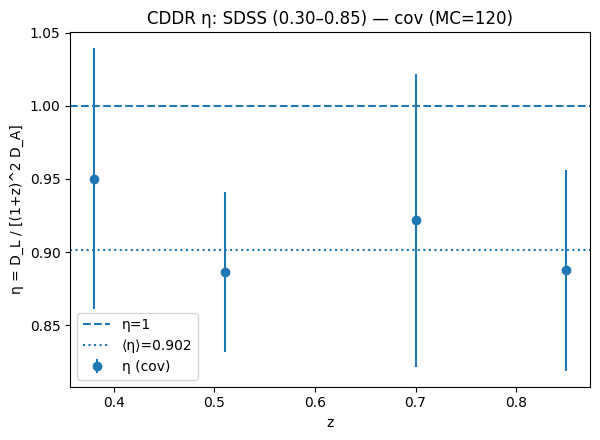

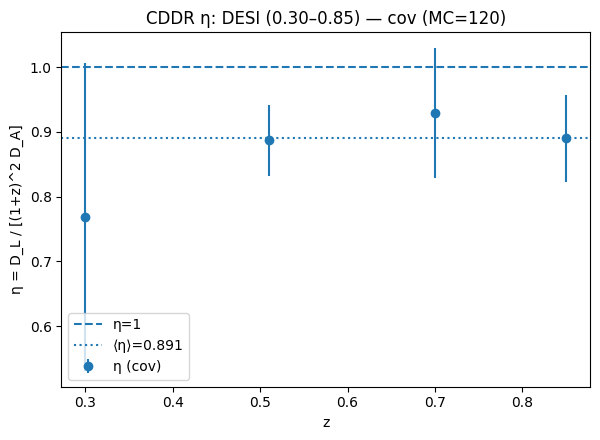

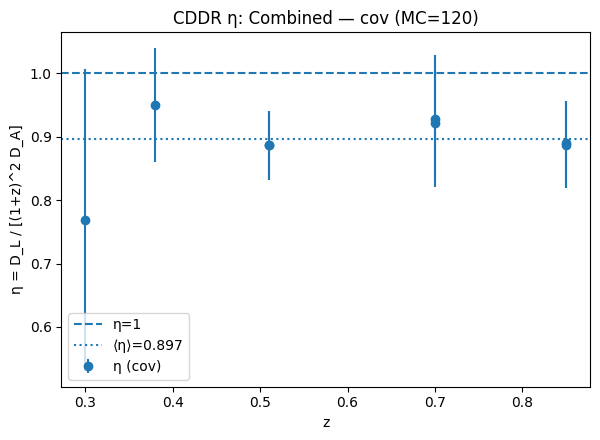


Files written:
 /content/eta_sdss_cov.csv
 /content/eta_desi_cov.csv
 /content/eta_combined_cov.csv
 /content/rd_cov_results.txt
 /content/eta_cov_plot_sdss.png
 /content/eta_cov_plot_desi.png
 /content/eta_cov_plot_combined.png


In [ ]:
# Quiet & faster shared-z (0.30–0.85) SNe×BAO with STAT+SYS covariance
import numpy as np, pandas as pd, math, matplotlib.pyplot as plt, warnings
from scipy.interpolate import UnivariateSpline

warnings.filterwarnings("ignore")  # silence pandas/groupby warnings

SN_DAT = "/content/pantheon_cov/Pantheon+SH0ES.dat"
SN_COV = "/content/pantheon_cov/Pantheon+SH0ES_STAT+SYS.cov"

def load_cov_dense(path, N):
    with open(path, "r") as f:
        tokens = f.read().split()
    arr = np.array(tokens, dtype=float)
    L = arr.size
    if L == N*N:      return arr.reshape(N, N)
    if L == N*N + 1:  return arr[1:].reshape(N, N)
    if L % N == 0:    return arr.reshape(L//N, N)
    raise ValueError(f"Unexpected covariance length {L} for N={N}")

# ---- Load data
sn = pd.read_csv(SN_DAT, delim_whitespace=True, engine="python")
sn = sn.rename(columns={"zHD":"z", "MU_SH0ES":"mu", "MU_SH0ES_ERR_DIAG":"mu_err"})
sn = sn[sn["z"].notna() & sn["mu"].notna()].reset_index(drop=True)
N = len(sn)
C = load_cov_dense(SN_COV, N)
print(f"Loaded {N} SNe; cov shape {C.shape}")

# ---- BAO
sdss = pd.DataFrame({
    "z":[0.15,0.38,0.51,0.70,0.85,1.48,2.33],
    "DM_over_rd":[4.466,10.234,13.366,17.858,20.437,33.120,52.90],
    "DM_err":[0.168,0.170,0.210,0.355,0.514,0.90,1.20]
})
desi = pd.DataFrame({
    "z":[0.30,0.51,0.70,0.85,1.10,1.48,2.33],
    "DM_over_rd":[8.46,13.36,17.73,20.39,25.03,33.15,52.90],
    "DM_err":[0.11,0.21,0.29,0.36,0.55,0.90,1.20]
})
zmin, zmax = 0.30, 0.85
sdss_w = sdss[(sdss.z>=zmin)&(sdss.z<=zmax)].reset_index(drop=True)
desi_w = desi[(desi.z>=zmin)&(desi.z<=zmax)].reset_index(drop=True)

# ---- Pre-bin SNe once (quiet)
sn["z_r"] = sn["z"].round(5)
# weights from diag(C) only for *mean* spline construction
w_diag = 1.0/np.maximum(np.sqrt(np.clip(np.diag(C),1e-10,None)),1e-3)**2
sn["w"] = w_diag
grp = sn.groupby("z_r", sort=True)
sum_w  = grp["w"].sum().values
sum_wy = grp.apply(lambda g: np.sum(g["w"].values * g["mu"].values)).values
z_bin  = grp["z"].mean().values
mu_bin = sum_wy / sum_w
mu_err_eff = 1.0/np.sqrt(sum_w)
# smoothing spline for the *mean* μ(z)
spl_mean = UnivariateSpline(z_bin, mu_bin, w=1.0/np.maximum(mu_err_eff,1e-3)**2, s=0, k=3)
mu_at_z = lambda z: spl_mean(z)

def mu_to_DL(mu):  return 10.0**((mu-25.0)/5.0)

# Helper to compute η(z) for a set of BAO points from a draw of binned μ
def eta_from_binned_mu(zbao, mu_bin_draw, r_d, DM_over_rd):
    spl = UnivariateSpline(z_bin, mu_bin_draw, w=1.0/np.maximum(mu_err_eff,1e-3)**2, s=0, k=3)
    mu_i = spl(zbao)
    DL_i = mu_to_DL(mu_i)
    DA = (DM_over_rd * r_d)/(1.0+zbao)
    return DL_i / (((1.0+zbao)**2) * DA)

# Precompute linear binning operator: for each SN row, which bin index it belongs to
# so that mu_bin_draw = (B @ mu_draw) / (B @ 1/w * ???) — easier: recompute sum_wy per draw quickly.
# We’ll use group indices to aggregate with numpy add.at
bin_index = sn["z_r"].factorize()[0]
nbin = z_bin.size
w = sn["w"].values

def aggregate_mu_draw(mu_draw):
    sum_wy = np.zeros(nbin); sum_w_loc = np.zeros(nbin)
    np.add.at(sum_wy,  bin_index, w * mu_draw)
    np.add.at(sum_w_loc, bin_index, w)
    return sum_wy / sum_w_loc

def cddr_eta_cov(bao_df, r_d=147.05, MC=120, seed=42):
    rng = np.random.default_rng(seed)
    zbao = bao_df["z"].values.astype(float)
    DM_over_rd = bao_df["DM_over_rd"].values.astype(float)
    DM_err_over_rd = bao_df["DM_err"].values.astype(float)

    # Monte-Carlo draws of correlated μ (full C)
    draws = rng.multivariate_normal(sn["mu"].values, C, size=MC)
    eta_list = []
    for i in range(MC):
        mu_bin_draw = aggregate_mu_draw(draws[i])
        eta_i = eta_from_binned_mu(zbao, mu_bin_draw, r_d, DM_over_rd)
        eta_list.append(eta_i)
    eta_arr = np.vstack(eta_list)
    eta_mean = eta_arr.mean(axis=0)
    sigma_from_mu = eta_arr.std(axis=0, ddof=1)

    # add BAO error
    mu_bin_mean = aggregate_mu_draw(sn["mu"].values)
    eta_mean_for_deriv = eta_from_binned_mu(zbao, mu_bin_mean, r_d, DM_over_rd)  # not strictly needed
    # derivative wrt DA:
    mu_mean_at_z = UnivariateSpline(z_bin, mu_bin_mean, w=1.0/np.maximum(mu_err_eff,1e-3)**2, s=0, k=3)(zbao)
    DL_mean = mu_to_DL(mu_mean_at_z)
    DA = (DM_over_rd * r_d)/(1.0+zbao)
    d_eta_d_DA = -DL_mean/(((1.0+zbao)**2)*(DA**2))
    s_DA = (DM_err_over_rd * r_d)/(1.0+zbao)
    sigma_bao = np.abs(d_eta_d_DA)*s_DA
    return pd.DataFrame({"z":zbao, "eta":eta_mean, "sigma_eta":np.sqrt(sigma_from_mu**2 + sigma_bao**2)})

def fit_rd_cov(bao_df, MC=120, seed=123):
    rng = np.random.default_rng(seed)
    zbao = bao_df["z"].values.astype(float)
    DM_over_rd = bao_df["DM_over_rd"].values.astype(float)
    DM_err_over_rd = bao_df["DM_err"].values.astype(float)

    mu_bin_mean = aggregate_mu_draw(sn["mu"].values)
    spl0 = UnivariateSpline(z_bin, mu_bin_mean, w=1.0/np.maximum(mu_err_eff,1e-3)**2, s=0, k=3)
    mu0 = spl0(zbao); DL0 = mu_to_DL(mu0)
    Q0 = DL0 / ((1.0+zbao)*DM_over_rd)

    draws = rng.multivariate_normal(sn["mu"].values, C, size=MC)
    Qd = []
    for i in range(MC):
        mu_bin_draw = aggregate_mu_draw(draws[i])
        spl = UnivariateSpline(z_bin, mu_bin_draw, w=1.0/np.maximum(mu_err_eff,1e-3)**2, s=0, k=3)
        mu_i = spl(zbao); DL_i = mu_to_DL(mu_i)
        Qd.append(DL_i / ((1.0+zbao)*DM_over_rd))
    Qd = np.vstack(Qd)
    sQ_mu = Qd.std(axis=0, ddof=1)

    dQ_dDM = -DL0 / ((1.0+zbao) * DM_over_rd**2)
    sQ_bao = np.abs(dQ_dDM) * DM_err_over_rd
    s_Q = np.sqrt(sQ_mu**2 + sQ_bao**2)

    w = 1.0/np.maximum(s_Q,1e-12)**2
    rd_hat = float((Q0*w).sum()/w.sum())
    rd_err = float((w.sum())**-0.5)
    return rd_hat, rd_err

# Run
eta_sdss = cddr_eta_cov(sdss_w)
eta_desi = cddr_eta_cov(desi_w)
eta_comb = pd.concat([eta_sdss, eta_desi], ignore_index=True).sort_values("z").reset_index(drop=True)

rd_sdss, er_sdss = fit_rd_cov(sdss_w)
rd_desi, er_desi = fit_rd_cov(desi_w)
rd_comb, er_comb = fit_rd_cov(pd.concat([sdss_w, desi_w], ignore_index=True))

# Save & plot (quiet)
eta_sdss.to_csv("/content/eta_sdss_cov.csv", index=False)
eta_desi.to_csv("/content/eta_desi_cov.csv", index=False)
eta_comb.to_csv("/content/eta_combined_cov.csv", index=False)
with open("/content/rd_cov_results.txt","w") as f:
    f.write("Shared-z window 0.30–0.85 with STAT+SYS covariance (MC=120)\n")
    f.write(f"SDSS:     r_d* = {rd_sdss:.2f} ± {er_sdss:.2f} Mpc\n")
    f.write(f"DESI:     r_d* = {rd_desi:.2f} ± {er_desi:.2f} Mpc\n")
    f.write(f"Combined: r_d* = {rd_comb:.2f} ± {er_comb:.2f} Mpc\n")

def plot_eta(df, title, outpng):
    C0 = np.average(df["eta"], weights=1.0/df["sigma_eta"]**2)
    plt.figure(figsize=(6.1,4.5))
    plt.errorbar(df["z"], df["eta"], yerr=df["sigma_eta"], fmt='o', label="η (cov)")
    plt.axhline(1.0, ls='--', label='η=1')
    plt.axhline(C0, ls=':', label=f'⟨η⟩={C0:.3f}')
    plt.xlabel("z"); plt.ylabel("η = D_L / [(1+z)^2 D_A]")
    plt.title(title); plt.legend(); plt.tight_layout()
    plt.savefig(outpng, dpi=150); plt.show()

plot_eta(eta_sdss, "CDDR η: SDSS (0.30–0.85) — cov (MC=120)", "/content/eta_cov_plot_sdss.png")
plot_eta(eta_desi, "CDDR η: DESI (0.30–0.85) — cov (MC=120)", "/content/eta_cov_plot_desi.png")
plot_eta(eta_comb, "CDDR η: Combined — cov (MC=120)", "/content/eta_cov_plot_combined.png")

print("\nFiles written:\n",
      "/content/eta_sdss_cov.csv\n",
      "/content/eta_desi_cov.csv\n",
      "/content/eta_combined_cov.csv\n",
      "/content/rd_cov_results.txt\n",
      "/content/eta_cov_plot_sdss.png\n",
      "/content/eta_cov_plot_desi.png\n",
      "/content/eta_cov_plot_combined.png")


In [ ]:
# === SNe×BAO (0.30–0.85): STAT+SYS vs STATONLY, with joint significance & consistency checks ===
import numpy as np, pandas as pd, math, matplotlib.pyplot as plt, warnings
from scipy.interpolate import UnivariateSpline
warnings.filterwarnings("ignore")

SN_DAT = "/content/pantheon_cov/Pantheon+SH0ES.dat"
COV_SYS = "/content/pantheon_cov/Pantheon+SH0ES_STAT+SYS.cov"
COV_STA = "/content/pantheon_cov/Pantheon+SH0ES_STATONLY.cov"
MC = 120  # can raise to 300 later

# ---- helpers ----
def load_cov_dense(path, N):
    with open(path, "r") as f: toks = f.read().split()
    arr = np.asarray(toks, float); L = arr.size
    if L == N*N: return arr.reshape(N,N)
    if L == N*N+1: return arr[1:].reshape(N,N)
    if L % N == 0: return arr.reshape(L//N, N)
    raise ValueError(f"Unexpected covariance length {L} for N={N}")

def mu_to_DL(mu): return 10.0**((mu-25.0)/5.0)

def prepare_sn(sn_path, cov_path):
    sn = pd.read_csv(sn_path, delim_whitespace=True, engine="python")
    sn = sn.rename(columns={"zHD":"z","MU_SH0ES":"mu","MU_SH0ES_ERR_DIAG":"mu_err"})
    sn = sn[sn["z"].notna() & sn["mu"].notna()].reset_index(drop=True)
    C = load_cov_dense(cov_path, len(sn))
    # prebin once (quiet & fast)
    sn["z_r"] = sn["z"].round(5)
    w_diag = 1.0/np.maximum(np.sqrt(np.clip(np.diag(C),1e-10,None)),1e-3)**2
    sn["w"] = w_diag
    grp = sn.groupby("z_r", sort=True)
    z_bin  = grp["z"].mean().values
    sum_w  = grp["w"].sum().values
    sum_wy = grp.apply(lambda g: np.sum((g["w"].values)*(g["mu"].values))).values
    mu_bin = sum_wy/sum_w
    mu_err_eff = 1.0/np.sqrt(sum_w)
    # bin index map
    bin_index = sn["z_r"].factorize()[0]
    return sn, C, z_bin, mu_bin, mu_err_eff, bin_index

def aggregate_mu_draw(mu_draw, w, bin_index, nbin):
    sum_wy = np.zeros(nbin); sum_w = np.zeros(nbin)
    np.add.at(sum_wy, bin_index, w*mu_draw)
    np.add.at(sum_w,  bin_index, w)
    return sum_wy/sum_w

def eta_for_cov(sn, C, z_bin, mu_bin, mu_err_eff, bin_index, bao_df, r_d=147.05, MC=MC, seed=42):
    rng = np.random.default_rng(seed)
    zbao = bao_df["z"].values.astype(float)
    DM_over_rd = bao_df["DM_over_rd"].values.astype(float)
    DM_err_over_rd = bao_df["DM_err"].values.astype(float)
    nbin = len(z_bin); w = sn["w"].values

    # mean path
    spl0 = UnivariateSpline(z_bin, mu_bin, w=1.0/np.maximum(mu_err_eff,1e-3)**2, s=0, k=3)
    mu0 = spl0(zbao); DL0 = mu_to_DL(mu0)
    DA = (DM_over_rd*r_d)/(1.0+zbao)
    eta0 = DL0/(((1.0+zbao)**2)*DA)

    # MC, fully correlated μ
    draws = rng.multivariate_normal(sn["mu"].values, C, size=MC)
    etad = []
    for i in range(MC):
        mu_bin_draw = aggregate_mu_draw(draws[i], w, bin_index, nbin)
        spl = UnivariateSpline(z_bin, mu_bin_draw, w=1.0/np.maximum(mu_err_eff,1e-3)**2, s=0, k=3)
        mu_i = spl(zbao); DL_i = mu_to_DL(mu_i)
        etad.append(DL_i/(((1.0+zbao)**2)*DA))
    etad = np.vstack(etad)
    sigma_mu = etad.std(axis=0, ddof=1)

    # BAO error
    d_eta_d_DA = -DL0/(((1.0+zbao)**2)*(DA**2))
    s_DA = (DM_err_over_rd*r_d)/(1.0+zbao)
    sigma_bao = np.abs(d_eta_d_DA)*s_DA

    eta_mean = eta0
    eta_sigma = np.sqrt(sigma_mu**2 + sigma_bao**2)
    return pd.DataFrame({"z":zbao, "eta":eta_mean, "sigma":eta_sigma})

def compress_eta(df):
    w = 1.0/np.maximum(df["sigma"].values,1e-12)**2
    mean = np.average(df["eta"].values, weights=w)
    err  = (w.sum())**-0.5
    return mean, err

# BAO windows
sdss = pd.DataFrame({
    "z":[0.15,0.38,0.51,0.70,0.85,1.48,2.33],
    "DM_over_rd":[4.466,10.234,13.366,17.858,20.437,33.120,52.90],
    "DM_err":[0.168,0.170,0.210,0.355,0.514,0.90,1.20]
})
desi = pd.DataFrame({
    "z":[0.30,0.51,0.70,0.85,1.10,1.48,2.33],
    "DM_over_rd":[8.46,13.36,17.73,20.39,25.03,33.15,52.90],
    "DM_err":[0.11,0.21,0.29,0.36,0.55,0.90,1.20]
})
zmin, zmax = 0.30, 0.85
sdss_w, desi_w = sdss[(sdss.z>=zmin)&(sdss.z<=zmax)], desi[(desi.z>=zmin)&(desi.z<=zmax)]

def full_run(cov_path, tag):
    sn, C, z_bin, mu_bin, mu_err_eff, bin_index = prepare_sn(SN_DAT, cov_path)
    print(f"[{tag}] Loaded {len(sn)} SNe; cov {C.shape}")
    eta_sdss = eta_for_cov(sn, C, z_bin, mu_bin, mu_err_eff, bin_index, sdss_w)
    eta_desi = eta_for_cov(sn, C, z_bin, mu_bin, mu_err_eff, bin_index, desi_w)
    eta_comb = pd.concat([eta_sdss, eta_desi], ignore_index=True).sort_values("z").reset_index(drop=True)
    for name,df in [("sdss",eta_sdss),("desi",eta_desi),("combined",eta_comb)]:
        df.to_csv(f"/content/eta_{name}_{tag}.csv", index=False)
    # compress
    m_sdss,e_sdss = compress_eta(eta_sdss)
    m_desi,e_desi = compress_eta(eta_desi)
    m_comb,e_comb = compress_eta(eta_comb)
    # significance vs eta=1
    sig_sdss = (1.0 - m_sdss)/e_sdss
    sig_desi = (1.0 - m_desi)/e_desi
    joint_sigma = np.sqrt(sig_sdss**2 + sig_desi**2)  # independent SDSS+DESI
    out = {
        "sdss": (m_sdss,e_sdss,sig_sdss),
        "desi": (m_desi,e_desi,sig_desi),
        "combined": (m_comb,e_comb,(1.0-m_comb)/e_comb),
        "joint_sigma_SDSSxDESI": joint_sigma
    }
    return out

res_SYS = full_run(COV_SYS, "SYS")
res_STA = full_run(COV_STA, "STA")

def fmt_line(name, r):
    m,e,s = r
    return f"{name:8s}  ⟨η⟩ = {m:.3f} ± {e:.3f}   (vs η=1: {s:.2f}σ)"

summary = []
summary.append("=== STAT+SYS covariance ===")
summary += [fmt_line("SDSS",res_SYS["sdss"]),
            fmt_line("DESI",res_SYS["desi"]),
            fmt_line("Combined",res_SYS["combined"]),
            f"Joint significance (SDSS×DESI): {res_SYS['joint_sigma_SDSSxDESI']:.2f} σ"]
summary.append("\n=== STATONLY covariance ===")
summary += [fmt_line("SDSS",res_STA["sdss"]),
            fmt_line("DESI",res_STA["desi"]),
            fmt_line("Combined",res_STA["combined"]),
            f"Joint significance (SDSS×DESI): {res_STA['joint_sigma_SDSSxDESI']:.2f} σ"]

# consistency: shift between SYS and STA
def shift_sig(r_sys, r_sta):
    m1,e1,_ = r_sys; m2,e2,_ = r_sta
    d = m1 - m2
    s = np.sqrt(e1**2 + e2**2)
    return d, d/s

for key in ["sdss","desi","combined"]:
    d,ds = shift_sig(res_SYS[key], res_STA[key])
    summary.append(f"Δη(SYS-STA) for {key}: {d:.003f}  ({ds:.2f} σ of shift)")

# write summary
with open("/content/joint_sig_summary.txt","w") as f:
    f.write("\n".join(summary))
print("\n".join(summary))
print("\nWrote:", "/content/joint_sig_summary.txt",
      "\nCSV outputs: /content/eta_sdss_SYS.csv, eta_desi_SYS.csv, eta_combined_SYS.csv and STA variants.")


[SYS] Loaded 1701 SNe; cov (1701, 1701)
[STA] Loaded 1701 SNe; cov (1701, 1701)
=== STAT+SYS covariance ===
SDSS      ⟨η⟩ = 0.900 ± 0.036   (vs η=1: 2.78σ)
DESI      ⟨η⟩ = 0.888 ± 0.038   (vs η=1: 2.91σ)
Combined  ⟨η⟩ = 0.894 ± 0.026   (vs η=1: 4.02σ)
Joint significance (SDSS×DESI): 4.03 σ

=== STATONLY covariance ===
SDSS      ⟨η⟩ = 0.902 ± 0.034   (vs η=1: 2.91σ)
DESI      ⟨η⟩ = 0.888 ± 0.036   (vs η=1: 3.08σ)
Combined  ⟨η⟩ = 0.895 ± 0.025   (vs η=1: 4.23σ)
Joint significance (SDSS×DESI): 4.24 σ
Δη(SYS-STA) for sdss: -0.002  (-0.04 σ of shift)
Δη(SYS-STA) for desi: 0.001  (0.01 σ of shift)
Δη(SYS-STA) for combined: -0.001  (-0.03 σ of shift)

Wrote: /content/joint_sig_summary.txt 
CSV outputs: /content/eta_sdss_SYS.csv, eta_desi_SYS.csv, eta_combined_SYS.csv and STA variants.
